In [52]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D

# $ I $

### Pocatecni podminky

In [53]:
pocet_castic = 500
teplota = 170                           # [J]
hmotnost_argonu = 39.948 * 1.66e-27     # [kg]
hustota_molarni = 0.14287 * 10**3       # N \V [mol/ m**3]

avogadrova_konst = 6.022E23
ciselna_hustota = hustota_molarni * avogadrova_konst  
objem = pocet_castic / ciselna_hustota  
strana_boxu = objem**(1/3)

boltzmanova_konstanta = 1.3806E-23      # [J*K^-1]
epsilon = 119.8 * boltzmanova_konstanta # [J/K]
sigma = 0.341E-9                        # [m]

r_cut = 3*sigma
tau = 0.1E-12
delta_t = tau
t_end = 1
r_ar = 71E-12                           # [m]

### Generace pocatecnich poloh

In [54]:
def generace_poc_poloh(pocet_castic, strana_boxu, sigma ):
    polohy = []
    krok = 5* sigma
    for y in np.arange(0, strana_boxu, krok):
        for z in np.arange(0, strana_boxu, krok):
            for x in np.arange(0, strana_boxu, krok):
                if len(polohy)< pocet_castic:
                    polohy.append([x,y,z])
    return np.array(polohy)

In [55]:
def generace_poc_poloh_v(pocet_castic, strana_boxu, sigma):
    krok = 2.5 * sigma
    x = np.arange(0, strana_boxu, krok)
    y = np.arange(0, strana_boxu, krok)
    z = np.arange(0, strana_boxu, krok)
    polohy = np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3)
    return polohy[:pocet_castic]  # Возвращаем только первые `pocet_castic` частиц


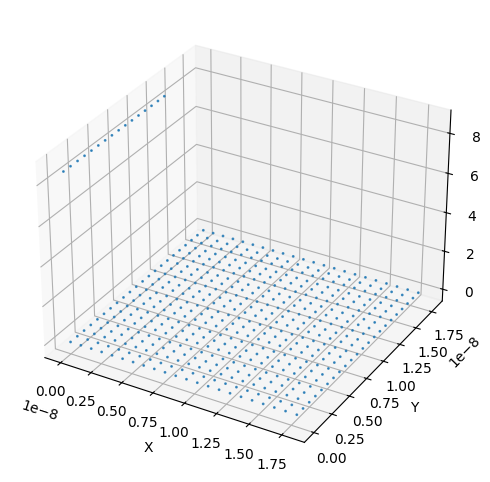

In [56]:
polohy = generace_poc_poloh_v(pocet_castic, strana_boxu, sigma)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(polohy[:, 0], polohy[:, 1], polohy[:, 2], s=1, alpha=0.8)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


### Generace rychlosti pomoci - Ekviparticni teoriumu Max Boltzman
$ \frac{1}{2} m \vec v^2  =\frac{1}{2} m (v^2_{x} +v^2_{y} +v^2_{z}) = \frac{1}{2} k_b T $,   
    kde $\frac{1}{2} k_b T $ - prvni stupen voltosti

In [57]:
def generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota):
    odchylka_rychlosti = np.sqrt(boltzmanova_konstanta * teplota / hmotnost_argonu)
    rychlosti = np.random.normal(0, odchylka_rychlosti, (pocet_castic, 3))
    rychlosti -= np.mean(rychlosti,axis= 0) # aby sum v = 0, system se nepochybuje
    return rychlosti

Zobrazim a overim sprravne rozlozeni pocatecnich rychlosti, kde hustota pravdepodobnosti Max B.

$f(v) = 4 \pi v^2 \left( \frac{m}{2 \pi k_B T} \right)^{3/2} \exp\left(-\frac{m v^2}{2 k_B T}\right)$


[-2.27373675e-13  3.12638804e-13  5.68434189e-13]


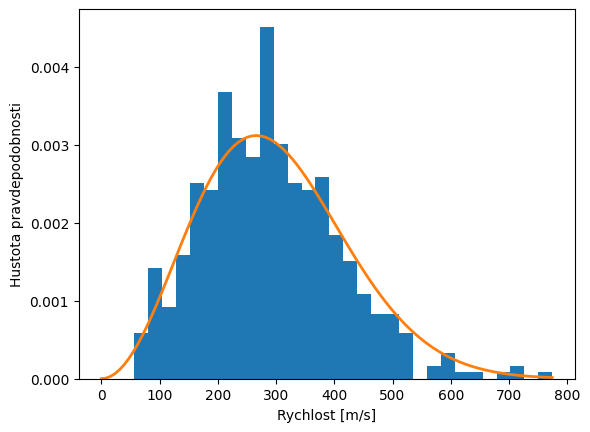

In [58]:
def plot_rychlosti(rychlosti, teplota, hmotnost_argonu, boltzmannova_konstanta):
    modul_rychl = np.sqrt(np.sum(rychlosti**2, axis = 1))
    
    v = np.linspace(0, np.max(modul_rychl), 100)
    f_v = 4 * np.pi * (v**2) * (hmotnost_argonu / (2 * np.pi * boltzmannova_konstanta * teplota))**1.5 \
        * np.exp(-hmotnost_argonu * v**2 / (2 * boltzmannova_konstanta * teplota))
    
    plt.hist(modul_rychl, density= True, bins = 30)
    plt.plot(v, f_v, linewidth = 2)
    plt.xlabel("Rychlost [m/s]")
    plt.ylabel("Hustota pravdepodobnosti")
    plt.show()    

rychlosti = generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota)
celkova_rychlost = np.sum(rychlosti, axis=0)
print(celkova_rychlost) # je to skoro 0
plot_rychlosti(rychlosti, teplota, hmotnost_argonu, boltzmanova_konstanta)


In [ ]:
$ P_{kin} = \frac{N k_b T}{V}$ $ P_{pot} = \frac{1}{3V} \sum_{i=1}^N \sum_{j=i+1}^N \vec r_{ij} \vec F_{ij} $

Vypocet vzdalenosti dvou castic metodou obrazu

$ r_{abs} = |\vec{r_{1}} - \vec{r_{2}}| = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + (z_1 - z_2)^2} $

In [59]:
def vzdalenost_dvou_casic(poloha_castice_1, poloha_castice_2, strana_boxu):
    vektor_vzdalenosti = poloha_castice_1 - poloha_castice_2
    vektor_vzdalenosti -= np.round(vektor_vzdalenosti / strana_boxu) * strana_boxu
    abs_vzdal = np.sqrt(np.sum(vektor_vzdalenosti**2))
    return abs_vzdal, vektor_vzdalenosti

# $II$

#### Postup Rychlostni Verlet:
1. Inic. P.P.: $ \vec{r_0}, \vec{V_0}, t, \Delta t $
2. Vypocet poc. polohy pro $ t = -\Delta t: \vec{r_{-\Delta t}}=\vec{r_0}- \Delta t * \vec{V_0}$

3. Vypocet poc. sil na zaklade poc. poloh:
    $ \vec F_0 = - \nabla U_{r_0}$ 
4. Iterace prez casove kroky:

    a) Aktualizace poloh pomoci Verleta:

    $r(t+ \Delta t)$
    
    b) Aktualizace sily pusobici mezi castice pomoci LJ:
    
     $ \vec F(t+\Delta t) = - \nabla U(r(t +\Delta t))$

    c) Aktualizace rychlosti

    $\vec V(t+ \Delta t) = \vec V(t) + \frac{\vec F(t) + \vec F(t+\Delta t)}{2m} * \Delta t $


## 2

In [60]:
def vyp_predchozich_polohh(polohy, delta_t, rychlosti):
    predchozi_polohy = polohy - delta_t * rychlosti
    return predchozi_polohy

## 4a
Aktualizace poloh
$\vec r(t+\Delta t) = 2 \vec r(t) - \vec r(t - \Delta t) + \frac{\vec F(t)}{m}  (\Delta t)^2$

In [61]:
def posun_castic(akt_polohy, pred_polohy, delta_t, hmotnost_argonu, strana_boxu, sily_mezi_castice):
    nove_polohy = 2 * akt_polohy - pred_polohy  + (sily_mezi_castice/hmotnost_argonu) * delta_t**2 
    nove_polohy %= strana_boxu
    return nove_polohy

## 4b
Sily mezi castice:
$ \vec F_{ij} = - \nabla U_{ij}$ 

LJ potencialni energie paru - mezi atomove iterakce:
$ U_{r_{ij}} = 4 \epsilon [ (\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ] $

Sila:
$ F_{ij} = 24 \epsilon [ (2\frac {\sigma}{r_{abs}})^{12} - (\frac {\sigma}{r_{abs}})^{6} ] \frac{\vec r_{ij}}{r_{abs}^2} $

kde $\vec r_{ij} = \vec r_i - \vec r_j$, a $\vec r = |\vec r_{ij}|$


In [62]:
def vyp_sil_mezi_castice(polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu):
    sily_mezi_castice = np.zeros_like(polohy)
    
    for i in range(pocet_castic-1):
        for j in range(i+1, pocet_castic):    
            abs_vzdal, vektor_vzdalenosti = vzdalenost_dvou_casic(polohy[i], polohy[j], strana_boxu) 
            if abs_vzdal < r_cut: 
                sila = 24 * epsilon *( 2*(sigma/abs_vzdal)**12 - (sigma/abs_vzdal)**6 ) *(vektor_vzdalenosti/ abs_vzdal**2)
                sily_mezi_castice[i] += sila
                sily_mezi_castice[j] -= sila # zakon akce a reakce
    print(sily_mezi_castice)
    return sily_mezi_castice

## 4c

In [63]:
def nove_rychlosti(akt_rychlosti, akt_sily, pred_sily, hmotnost_argonu, delta_t ):
    rychlosti = akt_rychlosti + ((akt_sily + pred_sily) / (2 * hmotnost_argonu)) * delta_t
    return rychlosti

## Verlet bez termostatu

In [64]:
# akt_polohy = generace_poc_poloh(pocet_castic, strana_boxu, sigma)
# pred_rych = generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota)
# pred_polohy = vyp_predchozich_polohh(akt_polohy, delta_t, pred_rych)
# pred_sily = vyp_sil_mezi_castice(pred_polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu)
# # print(f"Шаг {00}: Сумма скоростей: {np.sum(pred_rych, axis=0)}")

# for i in np.arange(0, 10*delta_t, delta_t):
#     akt_polohy = posun_castic(akt_polohy, pred_polohy, delta_t, hmotnost_argonu, strana_boxu, pred_sily)
#     akt_sily= vyp_sil_mezi_castice(akt_polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu)
#     akt_rychl = nove_rychlosti(pred_rych, akt_sily, pred_sily, hmotnost_argonu, delta_t )
#     # print(f"Шаг {i}: Сумма скоростей: {np.sum(akt_rychl, axis=0)}")
#     pred_polohy = deepcopy(akt_polohy)
#     pred_sily = deepcopy(akt_sily)
#     pred_rych = deepcopy(akt_rychl)

In [65]:
# plot_rychlosti(akt_rychl, teplota, hmotnost_argonu, boltzmanova_konstanta)

In [66]:
# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(akt_polohy[:, 0], akt_polohy[:, 1], akt_polohy[:, 2], s=1, alpha=0.8)
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# plt.show()

# $III$

## Verlet s korekci rychlosti pomoci termostatu

Berendsen thermostat - zmenena rychlosti pro dodreni pozadovane teploty
#### $ \frac{dT}{dt} = \frac{T_0 - T}{\tau } $, kde $ \Delta t = \tau$, $T_0$ - pozadovana teplota(170), $T$ - aktualni teplota

Pomoci Eulerove Metody upravim do tvaru:

$T(t+\Delta t) = T(t) + \frac{\Delta }{\tau} (T_0-T(t))$

kde $ T = \frac{1}{3Nk_B} \sum_{i=1}^N m |\vec V_i|^2 $, koef. mapovani $\lambda  = \sqrt{\frac{T(t+\Delta t)}{T(t)}} $, 

po dosazeni a upraveni $ \lambda = \sqrt{1+ \frac{\Delta t}{\tau} (\frac{T_0}{T(t)}-1)}$ jestli  $\lambda < 1$ - snizeni T, $\lambda > 1$ - zvyseni T 

$\vec V_i \to \lambda \vec V_i$

In [67]:
def berendsen_thermostat(aktualni_t, pozadovane_t, tau, delta_t, rychlosti):
    lambda_factor = np.sqrt(1 + (delta_t/tau) * (pozadovane_t/aktualni_t -1))
    rychlosti *= lambda_factor
    return rychlosti 

In [68]:
def vyp_aktualni_t(boltzmanova_konstanta, pocet_castic, hmotnost_argonu, rychlosti):
    rychl_kv = np.sum(rychlosti**2, axis = 1)
    suma_rychlosti = np.sum(rychl_kv)
    aktualni_t = (hmotnost_argonu * suma_rychlosti) / (3* pocet_castic*boltzmanova_konstanta)  
    return aktualni_t

In [ ]:
teploty_pred_zmenou = []
teploty_po_zmene = []
akt_polohy = generace_poc_poloh(pocet_castic, strana_boxu, sigma)
pred_rych = generace_poc_rychlosti(pocet_castic, hmotnost_argonu, boltzmanova_konstanta, teplota)
pred_polohy = vyp_predchozich_polohh(akt_polohy, delta_t, pred_rych)
pred_sily = vyp_sil_mezi_castice(pred_polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu)
teploty_pred_zmenou.append(vyp_aktualni_t(boltzmanova_konstanta, pocet_castic, hmotnost_argonu, pred_rych))

for i in np.arange(0, 10*delta_t, delta_t):
    akt_polohy = posun_castic(akt_polohy, pred_polohy, delta_t, hmotnost_argonu, strana_boxu, pred_sily)
    akt_sily= vyp_sil_mezi_castice(akt_polohy, pocet_castic, epsilon, sigma, r_cut, strana_boxu)
    akt_rychl = nove_rychlosti(pred_rych, akt_sily, pred_sily, hmotnost_argonu, delta_t )
    
    
    akt_t = vyp_aktualni_t(boltzmanova_konstanta, pocet_castic, hmotnost_argonu, akt_rychl)
    teploty_pred_zmenou.append(akt_t)
    akt_rychl = berendsen_thermostat(akt_t, teplota, tau, delta_t, akt_rychl)
    # print(f"Шаг {i}: Сумма скоростей: {np.sum(akt_rychl, axis=0)}")
    zmeneta_t = vyp_aktualni_t(boltzmanova_konstanta, pocet_castic, hmotnost_argonu, akt_rychl)
    teploty_po_zmene.append(zmeneta_t)
    
    pred_polohy = deepcopy(akt_polohy)
    pred_sily = deepcopy(akt_sily)
    pred_rych = deepcopy(akt_rychl)

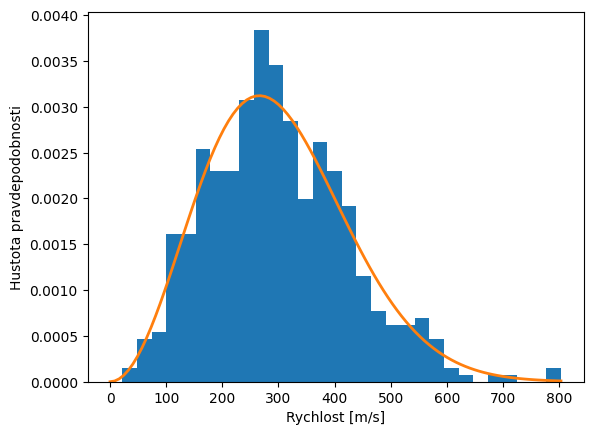

In [ ]:
plot_rychlosti(akt_rychl, teplota, hmotnost_argonu, boltzmanova_konstanta)

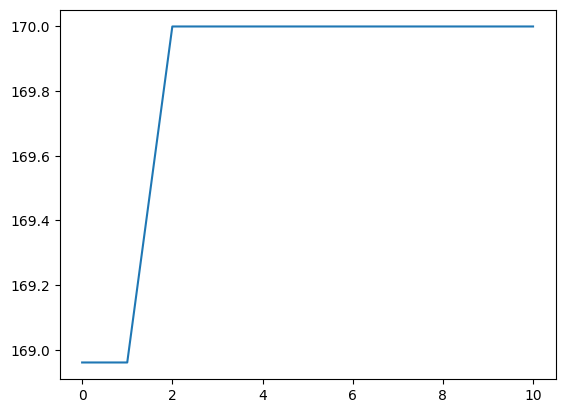

In [ ]:
plt.plot(teploty_pred_zmenou)

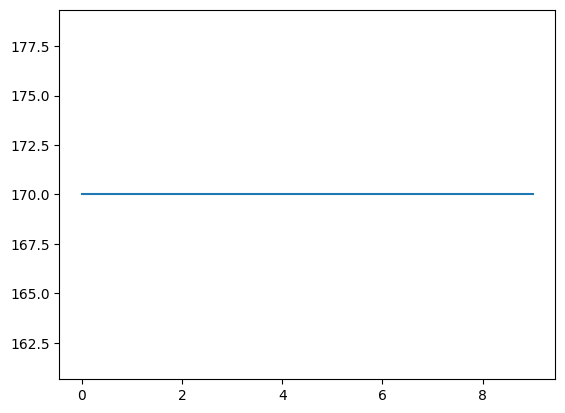

In [ ]:
plt.plot(teploty_po_zmene)

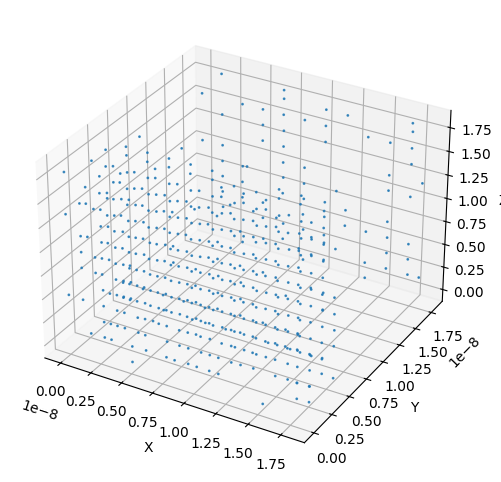

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(akt_polohy[:, 0], akt_polohy[:, 1], akt_polohy[:, 2], s=1, alpha=0.8)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [ ]:
def LJ_potencialni_energie_castice(abs_vzdal): # upravy pro abs_vzdal^2 
    if abs_vzdal > r_cut:
        U_paru = 0
    else:
        U_paru = 4 * epsilon *( (sigma/abs_vzdal)**12 - (sigma/abs_vzdal)**6 )
    return U_paru

In [ ]:
def LJ_potencialni_energie_castice(abs_vzdal): # upravy pro abs_vzdal^2 
    if abs_vzdal > r_cut**2:
        U_paru = 0
    else:
        U_paru = 4 * epsilon *( (sigma**2/abs_vzdal)**6 - (sigma**2/abs_vzdal)**3 )
    return U_paru

### Celkova potencialni energie 
$U_{total} = \sum_{i=1}^{N-1} \sum_{j=i+1}^{N} U_{r_{ij}}  $ 

In [ ]:
def celkova_pot_en(polohy):
    U_tot = 0
    for i in range(pocet_castic-1):
        for j in range(i+1, pocet_castic):     
            abs_vzdal = vzdalenost_dvou_casic(polohy[i], polohy[j])
            U_paru = LJ_potencialni_energie_castice(abs_vzdal)
            U_tot += U_paru
    return U_tot

Для плотности системы.
Для проверки равенства общего импульса нулю.
Для проверки значений потенциала Леннард-Джонса.